# Goal

Create dataset with `labels.json` from the [previous notebook](./1-create-label.ipynb) and some font files. Generating dataset from font files is a simple example of creating dataset yourself for problems that don't have pre-built dataset liked `MNIST`. In the near future, I will extract data from [ETL Character Database](http://etlcdb.db.aist.go.jp) for image-based model and from [KanjiVG](https://github.com/KanjiVG/kanjivg) for stroke-based model.

In [1]:
import os
import io
import time
import json
import traceback
import itertools
import inspect
import hashlib
import binascii

from tqdm import tqdm

In [2]:
from constants import *
from utils import *
from serializable import *

The label data was created from the previous notebook.

In [3]:
label_file = LABEL_FILENAME
label_file, os.path.exists(label_file)

('labels.json', True)

In [4]:
content = open(label_file, mode='r', encoding='utf-8').read()
print(content)

{
	"source": "hiragana.txt",
	"content": "あいうえおかきくけこさしすせそたちつてとなにぬねのまみむめもはひふへほやゆよらりるれろわん",
	"labels": [
		"あ",
		"い",
		"う",
		"え",
		"お",
		"か",
		"き",
		"く",
		"け",
		"こ",
		"さ",
		"し",
		"す",
		"せ",
		"そ",
		"た",
		"ち",
		"つ",
		"て",
		"と",
		"な",
		"に",
		"ぬ",
		"ね",
		"の",
		"ま",
		"み",
		"む",
		"め",
		"も",
		"は",
		"ひ",
		"ふ",
		"へ",
		"ほ",
		"や",
		"ゆ",
		"よ",
		"ら",
		"り",
		"る",
		"れ",
		"ろ",
		"わ",
		"ん"
	]
}


We created a method to parse the `json` data back.

In [5]:
print(inspect.getsource(LabelFile))

class LabelFile:
    def __init__(self, source: str, content: str, labels: list):
        self.source = source
        self.content = content
        self.labels = labels

    def __repr__(self):
        return repr(self.__dict__)

    @staticmethod
    def parse_obj(obj: dict):
        if not isinstance(obj, dict):
            raise Exception(f'{obj} is not a dict!')

        sample = LabelFile('', '', [])
        args = {}

        for key in sample.__dict__:
            if key not in obj:
                obj_str = repr(obj)
                if len(obj_str) > 80:
                    obj_str = obj_str[:40] + '...' + obj_str[-40:]

                raise Exception(f'{obj_str} does not contain key {repr(key)}!')

            args[key] = obj[key]

        return LabelFile(**args)



In [6]:
with open(label_file, mode='r', encoding='utf-8') as infile:
    obj = json.load(infile)

obj

{'source': 'hiragana.txt',
 'content': 'あいうえおかきくけこさしすせそたちつてとなにぬねのまみむめもはひふへほやゆよらりるれろわん',
 'labels': ['あ',
  'い',
  'う',
  'え',
  'お',
  'か',
  'き',
  'く',
  'け',
  'こ',
  'さ',
  'し',
  'す',
  'せ',
  'そ',
  'た',
  'ち',
  'つ',
  'て',
  'と',
  'な',
  'に',
  'ぬ',
  'ね',
  'の',
  'ま',
  'み',
  'む',
  'め',
  'も',
  'は',
  'ひ',
  'ふ',
  'へ',
  'ほ',
  'や',
  'ゆ',
  'よ',
  'ら',
  'り',
  'る',
  'れ',
  'ろ',
  'わ',
  'ん']}

In [7]:
label_file = LabelFile.parse_obj(obj)
type(label_file), label_file

(serializable.LabelFile,
 {'source': 'hiragana.txt', 'content': 'あいうえおかきくけこさしすせそたちつてとなにぬねのまみむめもはひふへほやゆよらりるれろわん', 'labels': ['あ', 'い', 'う', 'え', 'お', 'か', 'き', 'く', 'け', 'こ', 'さ', 'し', 'す', 'せ', 'そ', 'た', 'ち', 'つ', 'て', 'と', 'な', 'に', 'ぬ', 'ね', 'の', 'ま', 'み', 'む', 'め', 'も', 'は', 'ひ', 'ふ', 'へ', 'ほ', 'や', 'ゆ', 'よ', 'ら', 'り', 'る', 'れ', 'ろ', 'わ', 'ん']})

We put all all the font files in the a directory. We currently support `.otf` and `.ttf` font files only.

In [8]:
fonts_dir = FONTS_DIR
fonts_dir, os.path.exists(fonts_dir)

('fonts', True)

Define the output image size and font size to draw the character.

In [9]:
font_size = 64
image_size = 64

TODO write explanation about what the code does

In [10]:
print(inspect.getsource(fetch_font))

@measure_exec_time
def fetch_font(font_file: str, font_size=64, characters=list()):
    pillow_font = ImageFont.truetype(font=font_file, size=font_size)
    font_name = '_'.join(pillow_font.getname())

    # TODO test if this code is working or not by rendering the
    # actual image (with some uncommon kanji)
    ft_font = TTFont(font_file)
    supported_chars = []
    for cmap in ft_font['cmap'].tables:
        if cmap.isUnicode():
            for c in characters:
                if ord(c) in cmap.cmap:
                    supported_chars.append(c)

    return Font(font_name, pillow_font, font_size, font_file, supported_chars)



In [11]:
print(inspect.getsource(Font))

class Font:
    """
    Wrapper class for storing some data that we need to identify.

    For example:

    - the font name (not the file name)
    - the font size (pillow's ImageFont requires to be created with font
    size so I need to store that)
    - the ImageFont for using with pillow's drawing API
    - the font file path for using with `fonttools` to check if the font
    support a specific character or not. otherwise, it may give the tofu
    shape image.
    """

    def __init__(
        self,
        name: str,
        font: ImageFont.FreeTypeFont,
        size: int,
        path: str,
        supported_chars: list,
    ):
        self.name = name
        self.font = font
        self.size = size
        self.path = path
        self.supported_chars = supported_chars

    def __repr__(self):
        return repr((self.name, self.size, self.path))



In [12]:
labels = label_file.labels
font_list = []
file_list = os.listdir(fonts_dir)
for filename in file_list:
    child_path = os.path.join(fonts_dir, filename)

    if not os.path.isfile(child_path):
        print(f'Skipping directory {child_path}!')
        continue

    file_ext = os.path.splitext(filename)[1]
    file_ext = file_ext.lower()

    if (file_ext == '.ttf') or (file_ext == '.otf'):
        font = fetch_font(
            font_file=child_path,
            font_size=font_size,
            characters=labels,
        )

        font_list.append(font)
    else:
        print(f'Skipping unknown file type {child_path}!')
        continue

font_list

Skipping unknown file type fonts\readme.txt!


[('07YsashisaGothicTegaki_Regular', 64, 'fonts\\07YsashisaGothicTegaki_Regular.otf'),
 ('851MkPOP_Regular', 64, 'fonts\\851MkPOP_Regular.ttf'),
 ('ArmedBanana_Regular', 64, 'fonts\\ArmedBanana_Regular.ttf'),
 ('Chihaya Jyun_Regular', 64, 'fonts\\Chihaya_Jyun_Regular.ttf'),
 ('darts font_Regular', 64, 'fonts\\darts_font_Regular.ttf'),
 ('Dining message_Regular', 64, 'fonts\\Dining_message_Regular.ttf'),
 ('ElmerFont_Regular', 64, 'fonts\\ElmerFont_Regular.ttf'),
 ('Ghatee_Regular', 64, 'fonts\\Ghatee_Regular.ttf'),
 ('Gyate-Luminescence_Regular', 64, 'fonts\\Gyate-Luminescence_Regular.ttf'),
 ('HGKyokashotai_Medium', 64, 'fonts\\HGKyokashotai_Medium.ttf'),
 ('HonyaJi-Re_Regular', 64, 'fonts\\HonyaJi-Re_Regular.ttf'),
 ('HuiFont_Regular', 64, 'fonts\\HuiFont_Regular.ttf'),
 ('IPAGothic_Regular', 64, 'fonts\\IPAGothic_Regular.ttf'),
 ('Jiyucho_Regular', 64, 'fonts\\Jiyucho_Regular.ttf'),
 ('KanjiStrokeOrders_Regular', 64, 'fonts\\KanjiStrokeOrders_Regular.ttf'),
 ('kouichi.sakurai font fe

In [13]:
font.supported_chars

['あ',
 'い',
 'う',
 'え',
 'お',
 'か',
 'き',
 'く',
 'け',
 'こ',
 'さ',
 'し',
 'す',
 'せ',
 'そ',
 'た',
 'ち',
 'つ',
 'て',
 'と',
 'な',
 'に',
 'ぬ',
 'ね',
 'の',
 'ま',
 'み',
 'む',
 'め',
 'も',
 'は',
 'ひ',
 'ふ',
 'へ',
 'ほ',
 'や',
 'ゆ',
 'よ',
 'ら',
 'り',
 'る',
 'れ',
 'ろ',
 'わ',
 'ん']

In [14]:
unsupported_char_and_font_combinations = []
for font in tqdm(font_list):
    ns_chars = [c for c in labels if not c in font.supported_chars]

    if not len(ns_chars) == 0:
        unsupported_char_and_font_combinations.append((font.name, ns_chars))

unsupported_char_and_font_combinations

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 47568.54it/s]


[]

In [15]:
render_tasks = list(itertools.product(labels, font_list))
len(render_tasks)

2070

In [16]:
for char_text, font in render_tasks:
    break
    
char_text, font

('あ',
 ('07YsashisaGothicTegaki_Regular', 64, 'fonts\\07YsashisaGothicTegaki_Regular.otf'))

In [17]:
print(inspect.getsource(render_image))

@measure_exec_time
def render_image(c: str, font: Font, image_size=64) -> Image:
    pillow_font = font.font

    # we create a canvas at least twice as large as the font size to
    # prevent the character's pixel(s) from being cropped from drawing
    # on constrained size
    canvas_size = int(max(font.size*2, image_size))

    # the canvas is a grayscale image
    # background color is black (0)
    # text color is white (255)
    # you can experiment with other color spaces
    canvas = Image.new('L', (canvas_size, canvas_size), color=0)
    ctx = ImageDraw.Draw(canvas)
    # the variable names `canvax` and `ctx` are inspired from JavaScript
    # where we draw on HTMLCanvas

    # position the top-left position of the character's bounding box
    # (fontSize x fontSize square) on the canvas to draw the characters
    # https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html#PIL.ImageDraw.PIL.ImageDraw.ImageDraw.text
    char_x = (canvas_size - font.size) / 2
    char_y =

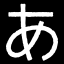

In [18]:
image = render_image(char_text, font, image_size)
image

In [19]:
type(image)

PIL.Image.Image

In [20]:
buffer = io.BytesIO()
image.save(buffer, format='PNG')
encoded_image = buffer.getvalue()

type(encoded_image), len(encoded_image)

(bytes, 1122)

In [ ]:
# m = hashlib.md5()
# m.update(encoded_image)
# image_data_md5_hash = m.digest()
# type(image_data_md5_hash), binascii.hexlify(image_data_md5_hash)

In [21]:
image_data_md5_hash = hashlib.md5(encoded_image).hexdigest()
type(image_data_md5_hash), image_data_md5_hash

(str, 'cb61562d38233f686de18ca8e36c8caa')

In [23]:
record_dict = {
    'HASH': image_data_md5_hash,
    'CHARACTER': char_text,
    'WIDTH': image_size,
    'HEIGHT': image_size,
    'DEPTH': 1, # grayscale image
    'PNG_IMAGE': encoded_image,
    'FONT_SIZE': font.size,
    'FONT_NAME': font.name,
    'DESCRIPTION': f'char {char_text} grayscale image created with font {font.name} and font size {font.size}',
}

record_dict

{'HASH': 'cb61562d38233f686de18ca8e36c8caa',
 'CHARACTER': 'あ',
 'WIDTH': 64,
 'HEIGHT': 64,
 'DEPTH': 1,
 'PNG_IMAGE': b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00@\x00\x00\x00@\x08\x00\x00\x00\x00\x8f\x02.\x02\x00\x00\x04)IDATx\x9c\xd5\x97[lTU\x18\x85Wg:\xd3\x0bmi\xa1\xb6\x15!i\xbd`\xa1\x11\xa2\x81\x86\xd1Z\x10\x13\x82\x01\x14\x8d&\xc4@\xa2\xc6TL\x89\x96\xd4\x07\r^\x12C\x9f4\xc6PcB\x88\x08F\x1f\x885\\\xc4`0\xc5\x10\xd3\x16*\xc6\xa8\xb4\x86rQiGJ\x9b\x16Z\x87^g\xfa\xf9p\xe6rn\x85\x81y\xe2\x7f:{\x9d\xb5\xd6\xf9\xf7\xd9\xfb\xff\xf79\xd2m\x1fi\xaeh\xe0\xdf\x8c\xfc\xf6\x14\\\xb7\x00\xbc\x94\x1c\xd7\xe3\x06\xe6HRq\n\x06}\x92t%U\x83\x81\x14\x0c\xfa%i,\x05\x831I\xf2\xa7`\x90'Iw\xde\x8aAZ\xb6$y\xf3$i\xc8}\x8b\xd8#\xce\xda\xf8\xee?\xf7\xfagg\\\xf5L\xa4\xcd\x96$M\xfa\x14\x0e\xe3m/\xcc\n\xce\xc8\x9b\xe9\x99\xa00\x1c\xf2x{2/\xf8\x96\x9d^5\xe8t\xda\xc1M\xc4].SH.a#\xc2\x97\\\x0c\xc6o\xc2\xc0;/q\x9d\x1e\xbb\xd8?\xa7\xb7\xa0p\xcc?\xbfe*\xb3?\x10\x90t\xf6\xd8\xa2\xb2\xf4\x91\xce\tO\xf7\x95\xf2\xde

In [24]:
record_datatype, encoded_record = XFormat.serialize_obj(record_dict)
record_datatype, encoded_record

(b'\x04',
 b"\x02\x04\x00\x00\x00HASH\x02 \x00\x00\x00cb61562d38233f686de18ca8e36c8caa\x02\t\x00\x00\x00CHARACTER\x02\x03\x00\x00\x00\xe3\x81\x82\x02\x05\x00\x00\x00WIDTH\x01\x04\x00\x00\x00@\x00\x00\x00\x02\x06\x00\x00\x00HEIGHT\x01\x04\x00\x00\x00@\x00\x00\x00\x02\x05\x00\x00\x00DEPTH\x01\x04\x00\x00\x00\x01\x00\x00\x00\x02\t\x00\x00\x00PNG_IMAGE\x00b\x04\x00\x00\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00@\x00\x00\x00@\x08\x00\x00\x00\x00\x8f\x02.\x02\x00\x00\x04)IDATx\x9c\xd5\x97[lTU\x18\x85Wg:\xd3\x0bmi\xa1\xb6\x15!i\xbd`\xa1\x11\xa2\x81\x86\xd1Z\x10\x13\x82\x01\x14\x8d&\xc4@\xa2\xc6TL\x89\x96\xd4\x07\r^\x12C\x9f4\xc6PcB\x88\x08F\x1f\x885\\\xc4`0\xc5\x10\xd3\x16*\xc6\xa8\xb4\x86rQiGJ\x9b\x16Z\x87^g\xfa\xf9p\xe6rn\x85\x81y\xe2\x7f:{\x9d\xb5\xd6\xf9\xf7\xd9\xfb\xff\xf79\xd2m\x1fi\xaeh\xe0\xdf\x8c\xfc\xf6\x14\\\xb7\x00\xbc\x94\x1c\xd7\xe3\x06\xe6HRq\n\x06}\x92t%U\x83\x81\x14\x0c\xfa%i,\x05\x831I\xf2\xa7`\x90'Iw\xde\x8aAZ\xb6$y\xf3$i\xc8}\x8b\xd8#\xce\xda\xf8\xee?\xf7\xfagg\\\xf5L\

In [28]:
deserialized_record = XFormat.deserialze_obj(encoded_record, record_datatype[0])
deserialized_record

{'HASH': 'cb61562d38233f686de18ca8e36c8caa',
 'CHARACTER': 'あ',
 'WIDTH': 64,
 'HEIGHT': 64,
 'DEPTH': 1,
 'PNG_IMAGE': b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00@\x00\x00\x00@\x08\x00\x00\x00\x00\x8f\x02.\x02\x00\x00\x04)IDATx\x9c\xd5\x97[lTU\x18\x85Wg:\xd3\x0bmi\xa1\xb6\x15!i\xbd`\xa1\x11\xa2\x81\x86\xd1Z\x10\x13\x82\x01\x14\x8d&\xc4@\xa2\xc6TL\x89\x96\xd4\x07\r^\x12C\x9f4\xc6PcB\x88\x08F\x1f\x885\\\xc4`0\xc5\x10\xd3\x16*\xc6\xa8\xb4\x86rQiGJ\x9b\x16Z\x87^g\xfa\xf9p\xe6rn\x85\x81y\xe2\x7f:{\x9d\xb5\xd6\xf9\xf7\xd9\xfb\xff\xf79\xd2m\x1fi\xaeh\xe0\xdf\x8c\xfc\xf6\x14\\\xb7\x00\xbc\x94\x1c\xd7\xe3\x06\xe6HRq\n\x06}\x92t%U\x83\x81\x14\x0c\xfa%i,\x05\x831I\xf2\xa7`\x90'Iw\xde\x8aAZ\xb6$y\xf3$i\xc8}\x8b\xd8#\xce\xda\xf8\xee?\xf7\xfagg\\\xf5L\xa4\xcd\x96$M\xfa\x14\x0e\xe3m/\xcc\n\xce\xc8\x9b\xe9\x99\xa00\x1c\xf2x{2/\xf8\x96\x9d^5\xe8t\xda\xc1M\xc4].SH.a#\xc2\x97\\\x0c\xc6o\xc2\xc0;/q\x9d\x1e\xbb\xd8?\xa7\xb7\xa0p\xcc?\xbfe*\xb3?\x10\x90t\xf6\xd8\xa2\xb2\xf4\x91\xce\tO\xf7\x95\xf2\xde